---
#Flight delay prediction
>(STAT652) Statistical Learning and Prediction Final Project

>Krishna Chaitanya Gopaluni

>**R version** 3.6.1 (2019-07-05)  x86_64-pc-linux-gnu

> List of packages to be installed are in section 1

##1. Install the packages and load all the libraries

In [0]:
list.of.packages <- c("ggplot2", "tidyverse", "nycflights13", "FeatureHashing", "mltools", "rsample", "xgboost", "gbm", "caret", "randomForest", "lars", "vtreat", "Metrics", "gam", "hashFunction", "glmnet", "vtreat", "xgboost")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [0]:
library(tidyverse)
library(nycflights13)
library(rsample)
library('Metrics')
library(gam)
library(hashFunction)
library(randomForest)
library(glmnet)
library(vtreat)
library(xgboost)
library(gbm) 

##2. Read the flight dataset and check the dimentions

In [0]:
flight_train <- read_csv("https://github.com/SFUStatgen/SFUStat452/raw/master/Project652/fltrain.csv.gz")

In [0]:
dim(flight_train)# rows  and cols
str(flight_train) # get the column names and type

##3.Checking the amount of missing values in each column and drop the rows/cols which has more missing values

In [0]:
colMeans(is.na(flight_train)) 

In [0]:
fl <- flight_train
#Drop columns where there are more than 12.5% missing values
fl <- fl[, -which(colMeans(is.na(flight_train)) > 0.125)]
#Next, Drop the rows which has the NA entries
fl <- na.omit(fl)

In [0]:
#dimentions and the summary of the  dataset
dim(fl)
summary(fl)

[1] 165021     34

     year.x         month             day           dep_time    sched_dep_time
 Min.   :2013   Min.   : 1.000   Min.   : 1.00   Min.   :   1   Min.   : 500  
 1st Qu.:2013   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.: 917   1st Qu.: 915  
 Median :2013   Median : 7.000   Median :16.00   Median :1421   Median :1411  
 Mean   :2013   Mean   : 6.557   Mean   :15.74   Mean   :1359   Mean   :1349  
 3rd Qu.:2013   3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:1750   3rd Qu.:1730  
 Max.   :2013   Max.   :12.000   Max.   :31.00   Max.   :2400   Max.   :2339  
   dep_delay          arr_time    sched_arr_time   arr_delay       
 Min.   : -43.00   Min.   :   1   Min.   :   1   Min.   : -75.000  
 1st Qu.:  -5.00   1st Qu.:1110   1st Qu.:1128   1st Qu.: -17.000  
 Median :  -2.00   Median :1557   Median :1612   Median :  -6.000  
 Mean   :  11.19   Mean   :1521   Mean   :1551   Mean   :   4.878  
 3rd Qu.:   9.00   3rd Qu.:1949   3rd Qu.:1953   3rd Qu.:  12.000  
 Max.   :1301.00   Max.   :2400   Max. 

##4.FetureHashing the categorical columns

In [0]:
for(i in 1:ncol(fl)) {
  if(typeof(fl[[i]]) == "character") {
    fl[[i]] <- as.numeric(unlist(lapply(fl[[i]], murmur3.32)))
    
  }
}

In [0]:
unique(flight_train$carrier)
unique(fl$carrier)

##5. Assumptions to drop other columns

 Following columns were removed based on these assumtions

- year.x is constant and all the datapoints are from year 2013.
- month, day, hour, minute were removed because this information is present in time_hour column.
- tzone, dst, tz  were removed because these are the constant values for all the observations.
- name full name of destination airport which we have already in dst column
- tailnum, flight are just numeric representation and we can drop them.
- dep_tim, arr_time, arr_delay, air_time will not be known in advance and not needed for the models. 


In [0]:
fl <- as.data.frame(subset(fl, select=-c(year.x, month, day, hour, minute, tzone, dst, tz, name, tailnum, flight, dep_time, arr_time, arr_delay, air_time)))

In [0]:
fl %>% head(10)

##6. Summarizing the target variable `dep_delay' using quantiles.

In [0]:
quantile(fl$dep_delay, probs = c(0.01,0.05,0.1,0.25,.5,.75,.90,.95,.99))

Top 10 delayed flightdelays

In [0]:
fl%>% arrange(desc(dep_delay)) %>% head(10)

##7. Density plot of response variable 

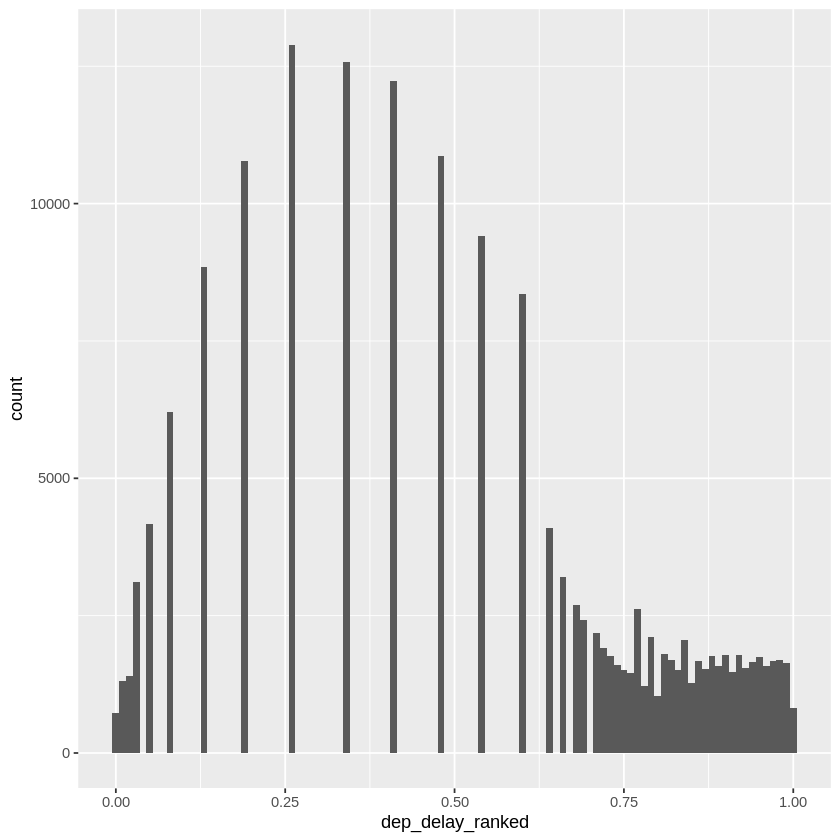

In [0]:
den <- nrow(fl)+1 # to avoid truncate of last value during ranking 
fl <- fl %>% mutate(dep_delay_ranked = rank(dep_delay)/den) # as the dep_delay values are skewed, create new column with scaled and ranked dep_delay col
ggplot(fl,aes(x=dep_delay_ranked)) + geom_histogram(binwidth=.01)

##8. Other preprocessing and feature engineering techniques

- Changing 'pres' to binary to show the presence of precipitation

In [0]:
fl <- fl %>% mutate(precip = as.numeric(fl$precip > 0))

- Bining the `sched_dep_time` and `sched_arr_time` in buckets of 23

In [0]:
fl <- fl %>% mutate(sched_dep_time_bin = as.numeric(floor(fl$sched_dep_time/100))) %>% select(-sched_dep_time)

fl <- fl %>% mutate(sched_arr_time_bin = as.numeric(floor(fl$sched_arr_time/100))) %>% select(-sched_arr_time)

- Calculating the day of year, day of week and month of year from `time_hour`

In [0]:
fl <- fl %>% mutate(d_of_year = as.numeric(strftime(fl$time_hour, format = "%j"))) %>% mutate(d_of_week = as.numeric(strftime(fl$time_hour, format = "%w"))) %>% mutate(m_of_year = as.numeric(strftime(fl$time_hour, format = "%m"))) %>% select(-time_hour)

##9. Associations of `dep_delay_ranked` and quantitative predictors

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


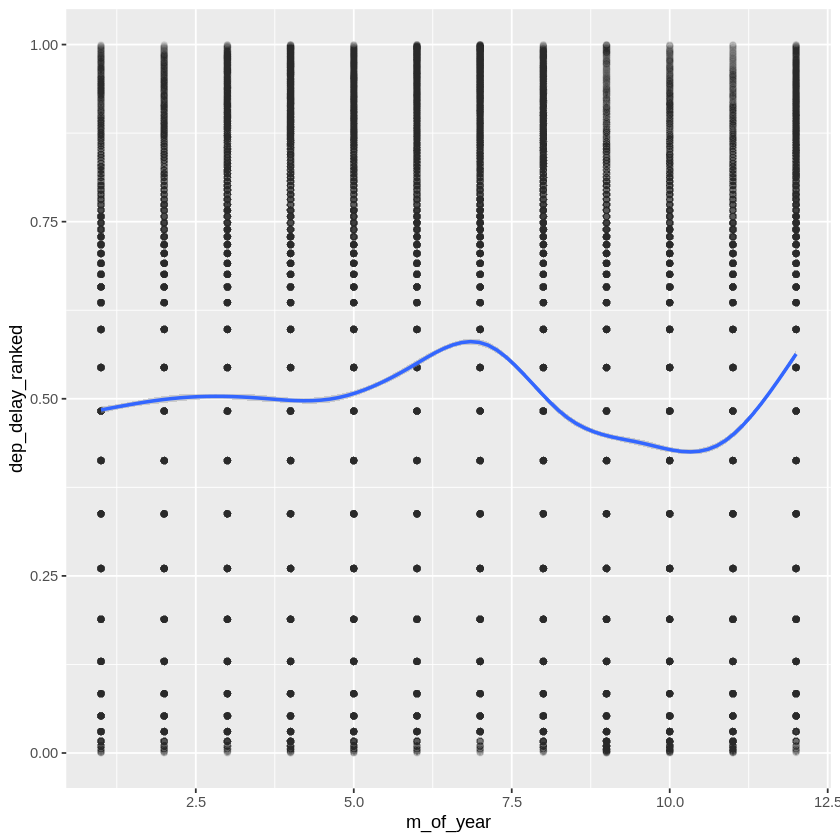

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


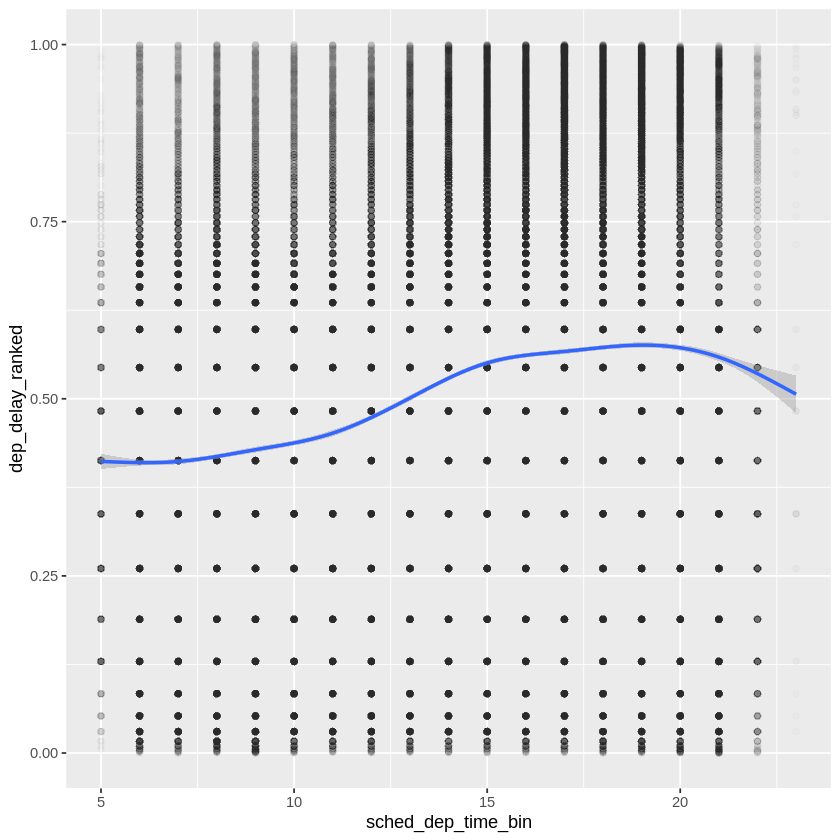

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


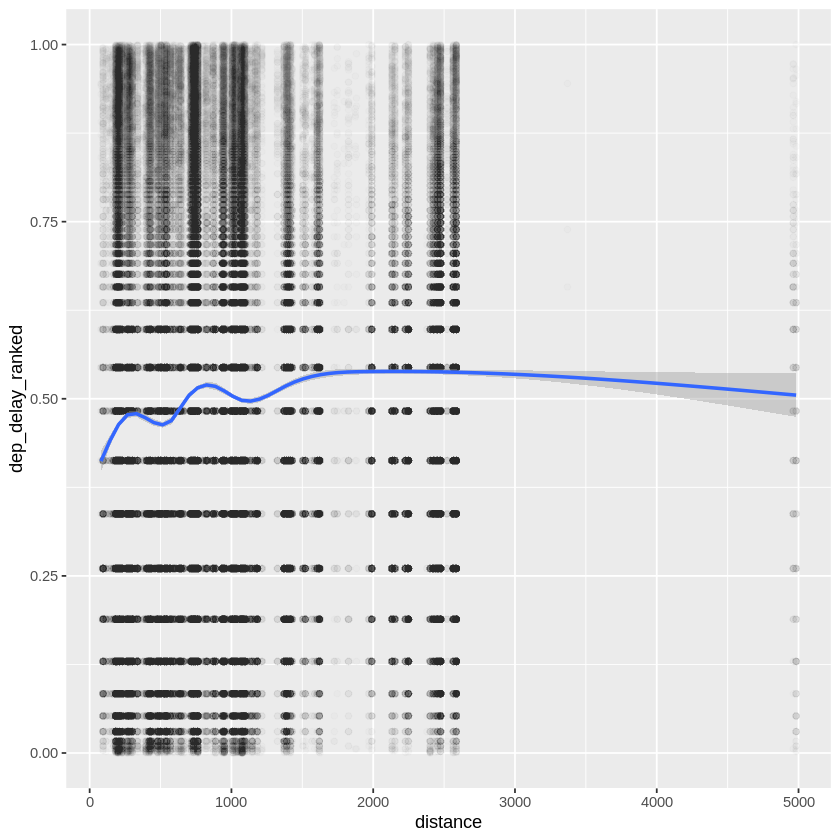

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


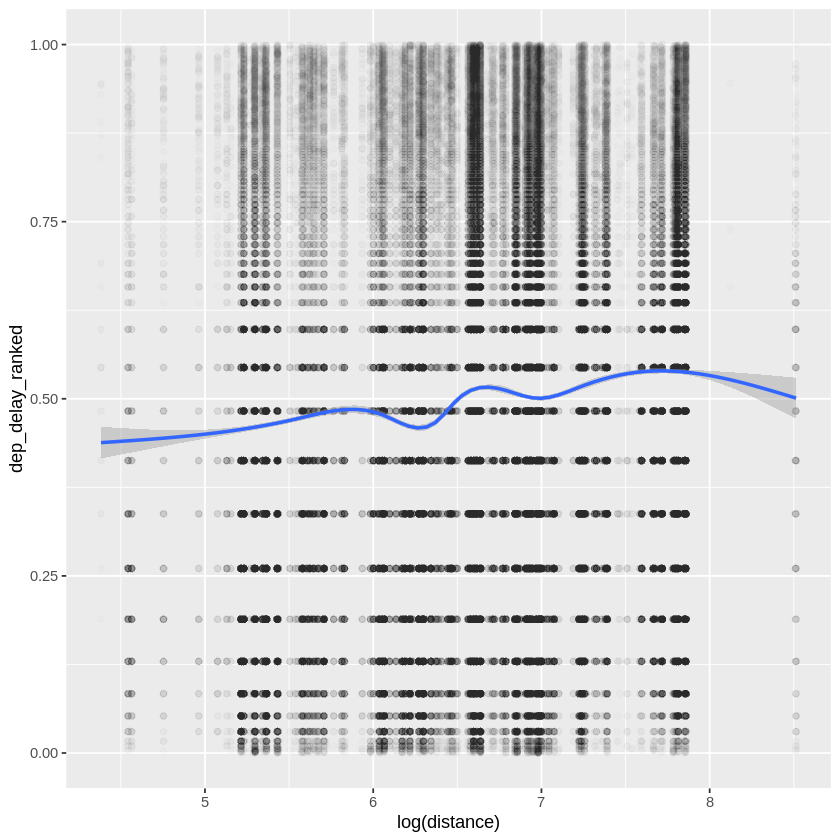

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


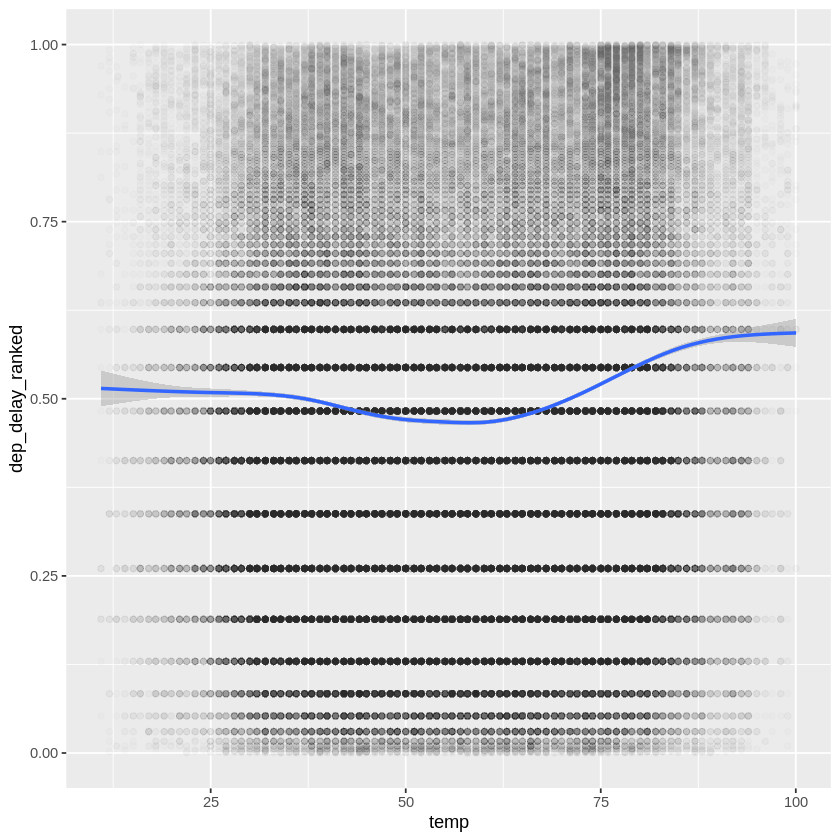

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


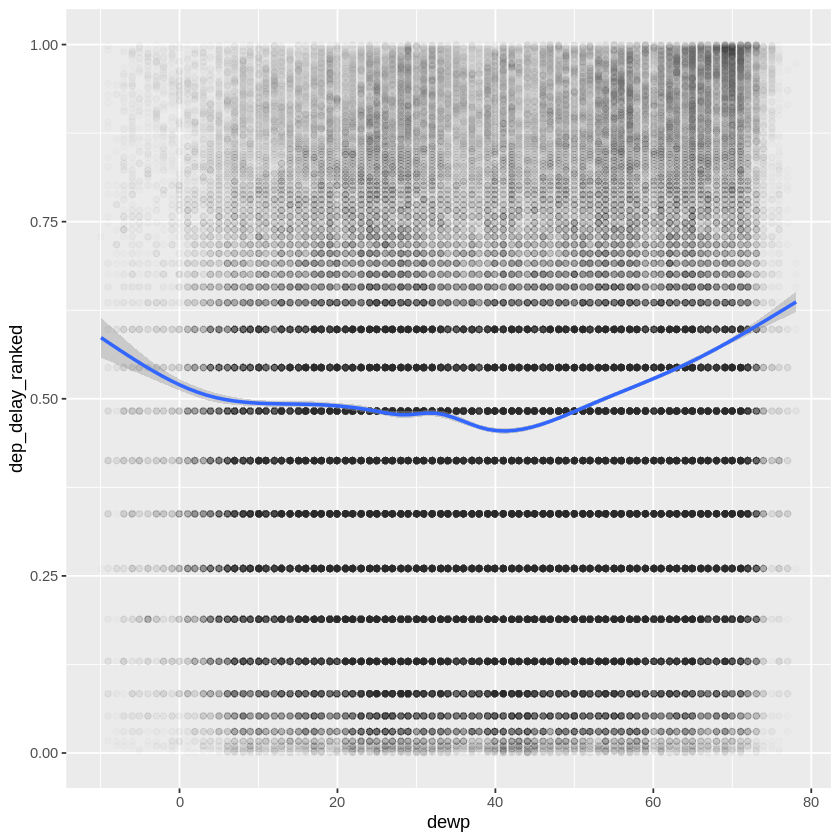

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


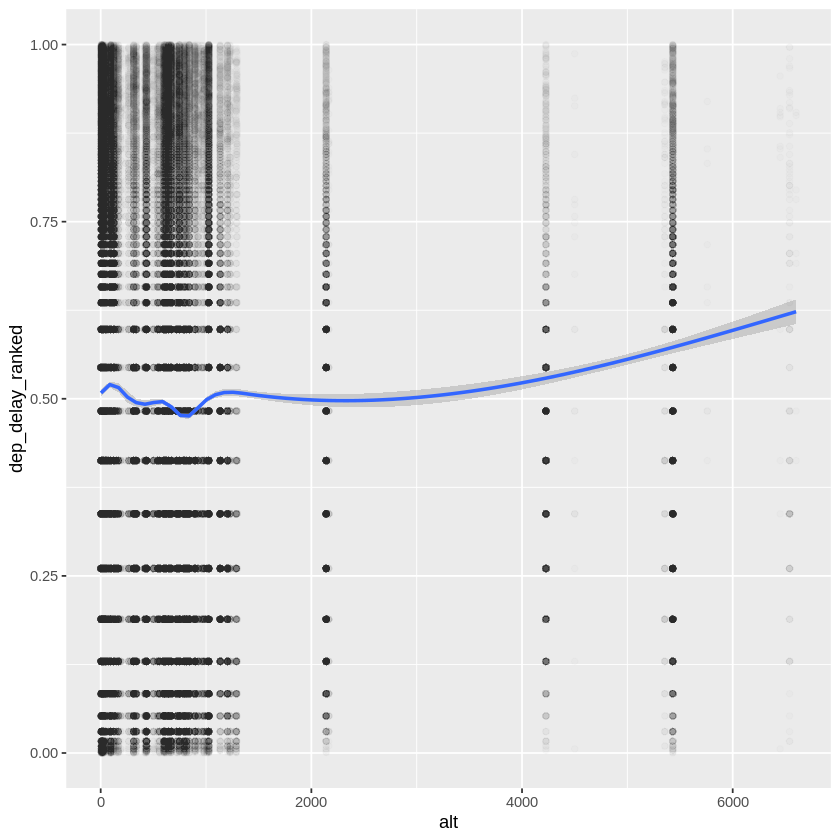

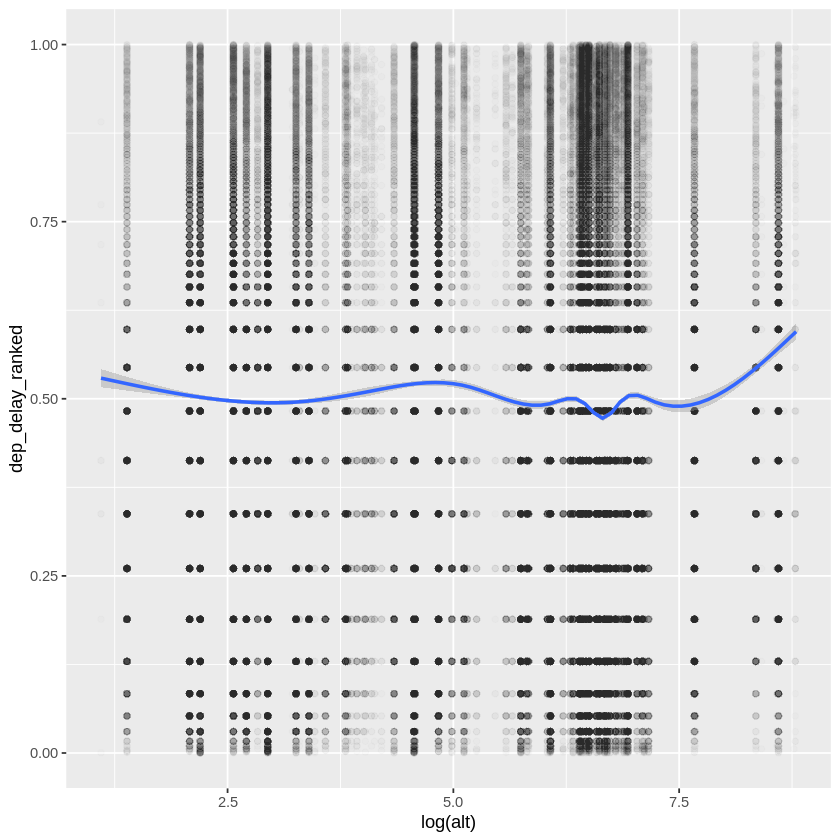

In [0]:
ggplot(fl,aes(x=m_of_year,y=dep_delay_ranked)) + geom_point(alpha=.01) + geom_smooth()
# The relationship shows the the depatures are high in the months of summer
# There's also increase in the departure delays in the month of winter.

ggplot(fl,aes(x=sched_dep_time_bin,y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()
# With the increase in the time there is increase in the departure delays.

ggplot(fl,aes(x=distance,y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()
ggplot(fl,aes(x=log(distance),y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()
# Departure delays are increasing with distance hence we transform it to log distance below
fl <- mutate(fl,logdistance = log(distance)) %>% select(-distance)

ggplot(fl,aes(x=temp,y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()
# Bigger departure delays when the temperatures are too high or too low
ggplot(fl,aes(x=dewp,y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()


ggplot(fl,aes(x=alt,y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()
ggplot(fl,aes(x=log(alt),y=dep_delay_ranked)) + geom_point(alpha=0.01) + geom_smooth()
# Similar to distance, replace alt with log(alt)
fl <- mutate(fl,logalt = log(alt)) %>% select(-alt, -dep_delay_ranked)

In [0]:
summary(fl)

   dep_delay          carrier               origin          
 Min.   : -43.00   Min.   :-2.060e+09   Min.   :-1.124e+09  
 1st Qu.:  -5.00   1st Qu.:-6.295e+08   1st Qu.:-1.124e+09  
 Median :  -2.00   Median : 7.488e+08   Median : 1.791e+09  
 Mean   :  11.19   Mean   : 1.270e+08   Mean   : 9.536e+08  
 3rd Qu.:   9.00   3rd Qu.: 8.602e+08   3rd Qu.: 2.135e+09  
 Max.   :1301.00   Max.   : 1.771e+09   Max.   : 2.135e+09  
      dest                 temp             dewp           humid       
 Min.   :-2.070e+09   Min.   : 10.94   Min.   :-9.94   Min.   : 13.00  
 1st Qu.:-9.143e+08   1st Qu.: 42.08   1st Qu.:24.98   1st Qu.: 42.30  
 Median : 3.952e+08   Median : 57.02   Median :41.00   Median : 54.22  
 Mean   : 9.066e+07   Mean   : 56.94   Mean   :40.22   Mean   : 56.08  
 3rd Qu.: 9.192e+08   3rd Qu.: 71.96   3rd Qu.:57.02   3rd Qu.: 69.28  
 Max.   : 2.091e+09   Max.   :100.04   Max.   :78.08   Max.   :100.00  
    wind_dir     wind_speed         precip           pressure   
 Min

##10. Split the test train set using `rsample` library

In [0]:
set.seed(123)
fl_split <- initial_split(fl, prop = .8)
fl_train <- training(fl_split)
fl_test  <- testing(fl_split)

##11. Baseline model and the metrics 

In [0]:
##mean absolute error
mean <- abs(mean(fl_test$dep_delay))
fl_test_dummy <- fl_test %>% mutate(dep_delay_calc = abs(fl_test$dep_delay - mean)) %>% select(dep_delay_calc)
mae_dummy <- mean(fl_test_dummy$dep_delay_calc)
mae_dummy

mse_dummy <- var(fl_test$dep_delay)
mse_dummy#Mean Squared Error
rmse_dummy <- sqrt(var(fl_test$dep_delay))
rmse_dummy#Root Mean Squared Error

[1] 21.57717

[1] 1428.559

[1] 37.79628

##12. GAM and its metrics on training and test splits

In [0]:
gam.fit <- gam(
  formula = dep_delay ~ .,
  family = gaussian,
  data = fl_train
  )
pred_gam <- predict(gam.fit, fl_test)

mae_gam <- mae(fl_test$dep_delay, pred_gam)#mean absolute error for the gam
mae_gam
mse_gam <- mse(fl_test$dep_delay, pred_gam)#Calculate Mean Squared Error (MAE) for test data 
mse_gam
rmse_gam <- rmse(fl_test$dep_delay, pred_gam)# Calculate Root Mean Squared Error for test data
rmse_gam

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

[1] 20.31503

[1] 1336.671

[1] 36.56051

##13. Implementing Lasso regression and metrics on training and test splits

In [0]:
X_train <- model.matrix(dep_delay ~., data=fl_train)

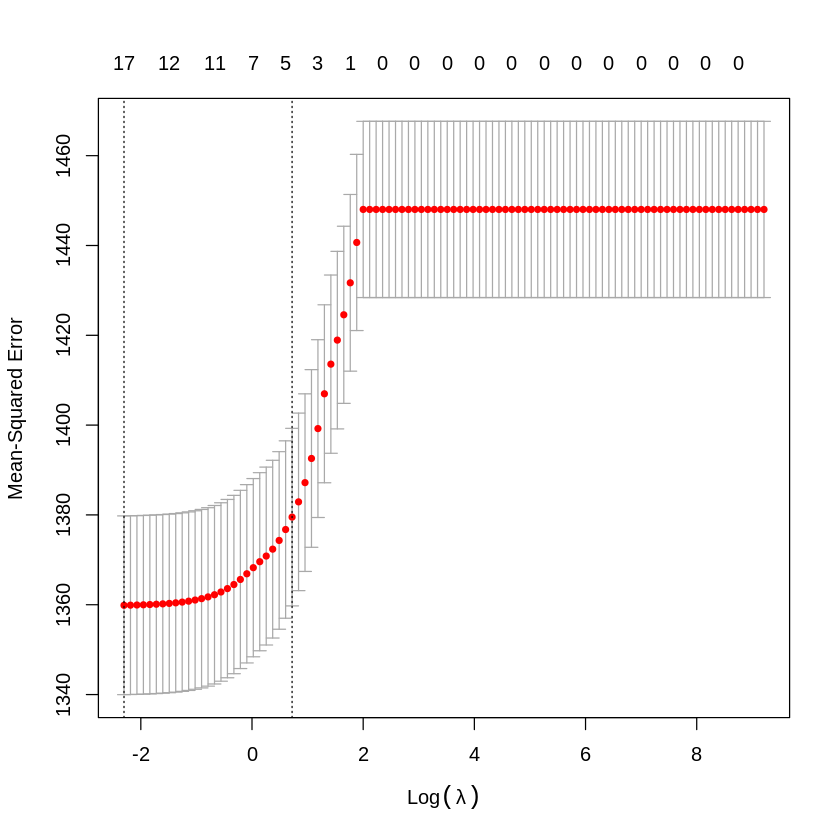

In [0]:
lambdas <- 10^{seq(from=-1,to=4,length=100)}
cv.lafit <- cv.glmnet(X_train,fl_train$dep_delay,alpha=1,lambda=lambdas)
plot(cv.lafit)

- **Finding the best value of the lambda for lasso regression and calculating metrics**

In [0]:
best_lam <- cv.lafit$lambda.min

In [0]:
best_lam

[1] 0.1

In [0]:
X_test <- model.matrix(dep_delay ~., data=fl_test)

In [0]:
lasso_best <- glmnet(X_train,fl_train$dep_delay, alpha = 1, lambda = best_lam)
pred <- predict(lasso_best, s = best_lam, newx =X_test)

In [0]:
#Calculate Mean Absolute Error (MAE) for test data
mae_lasso <- mae(fl_test$dep_delay, pred)
mae_lasso
#Calculate Mean Squared Error (MAE) for test data
mse_lasso <- mse(fl_test$dep_delay, pred)
mse_lasso
#Calculate Root Mean Squared Error for test data
rmse_lasso <- rmse(fl_test$dep_delay, pred)
rmse_lasso

[1] 20.30545

[1] 1337.785

[1] 36.57575

##14. Implementing Ridge regression and metrics on training and test splits

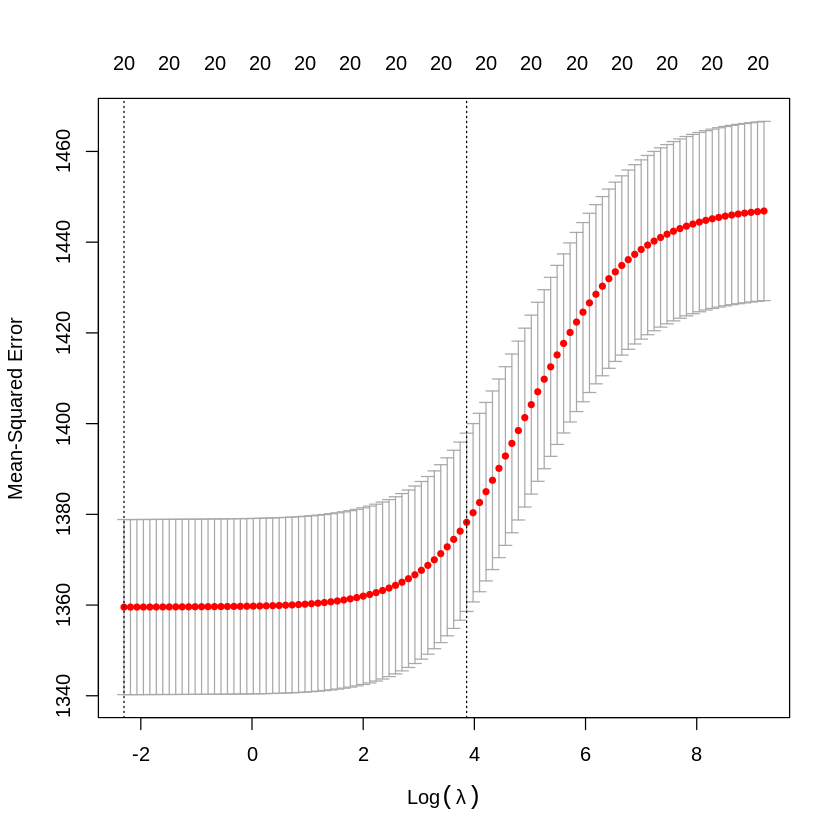

In [0]:
lambda_seq <- 10^seq(2, -2, by = -.1)
cv.rifit <- cv.glmnet(X_train,fl_train$dep_delay,alpha=0,lambda=lambdas)
best_lam_rid <- cv.rifit$lambda.min
plot(cv.rifit)

In [0]:
best_lam_rid

[1] 0.1

In [0]:
ridge_best <- glmnet(X_train,fl_train$dep_delay, alpha = 0, lambda = best_lam_rid)
pred_ridge <- predict(ridge_best, s = ridge_best, newx =X_test)

In [0]:
#Calculate Mean Absolute Error (MAE) for test data
mae_ridge <- mae(fl_test$dep_delay, pred_ridge)
mae_ridge
#Calculate Mean Squared Error (MAE) for test data
mse_ridge <- mse(fl_test$dep_delay, pred_ridge)
mse_ridge
#Calculate Root Mean Squared Error for test data
rmse_ridge <- rmse(fl_test$dep_delay, pred_ridge)
rmse_ridge

[1] 20.31448

[1] 1336.951

[1] 36.56433

##15. Generalized Boosted Regression Model (GBM) and metrics on training and test splits. Feature importance plot included.

,var,rel.inf
,<fct>,<dbl>
sched_dep_time_bin,sched_dep_time_bin,38.834055234
dewp,dewp,25.908216630
pressure,pressure,16.182219023
humid,humid,13.608225825
d_of_year,d_of_year,3.691197376
origin,origin,0.643414692
visib,visib,0.479724168
precip,precip,0.348151254
temp,temp,0.123262539


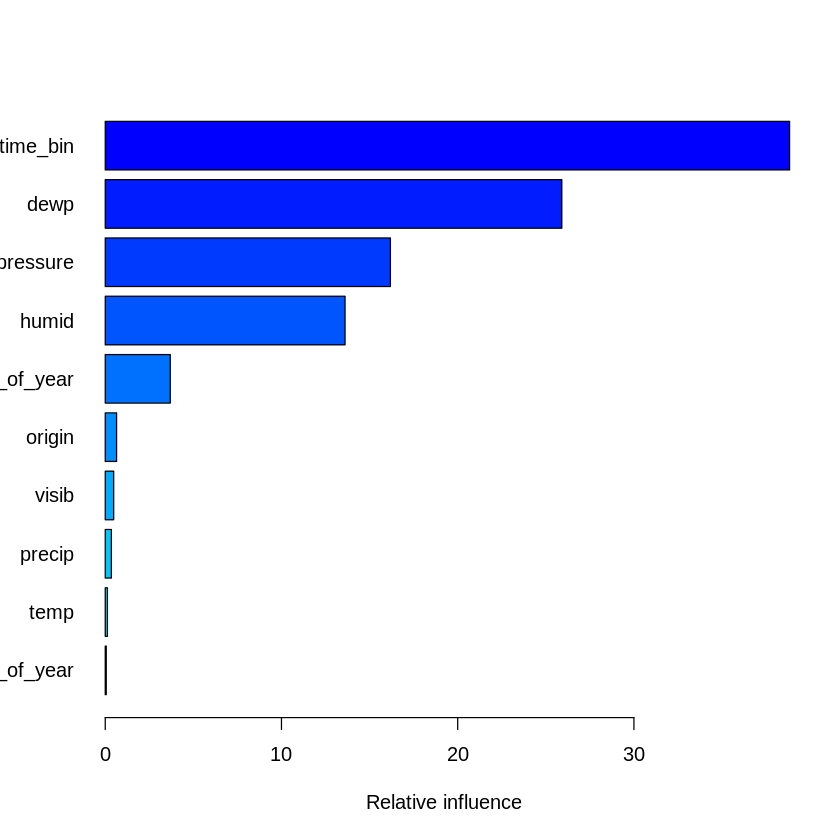

In [0]:
##Fit a GBM model on the train data `fl_train` using 5 fold cross validation
gbm.fit <- gbm(
  formula = dep_delay ~ .,
  distribution = "gaussian",
  data = fl_train,
  n.trees = 2500,
  interaction.depth = 3,
  shrinkage = 0.001,
  cv.folds = 5,
  n.cores = NULL, # will use all cores by default
  verbose = FALSE
)

summary.gbm(gbm.fit, n.trees = 2000, cBars=10, plotit=TRUE, normalize=TRUE, order=TRUE, las = 1)#Print the feature importance of the fitted GBM model
# sched_dep_time_bin, dewp, pressure, humid are important features with more than 10%
# There were 20 predictors of which 15 had non-zero influence.

- Calculate RMSE of CV Error

In [0]:
sqrt(min(gbm.fit$cv.error))

[1] 36.32215

[1] 2500

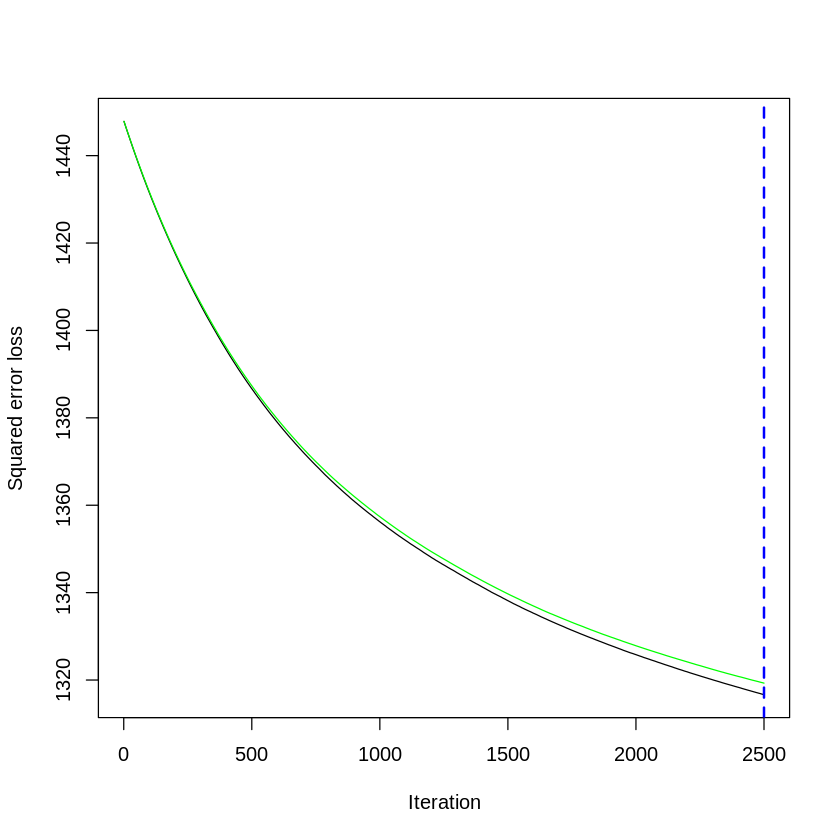

In [0]:
gbm.perf(gbm.fit, method = "cv")

- **GBM Matrices on predictions**

In [0]:
pred_gbm <- predict(gbm.fit, n.trees = 2500, fl_test)#Predict the target `dep_delay` on `fl_test`
mae_gbm <- mae(fl_test$dep_delay, pred_gbm) #Calculate Mean Absolute Error (MAE) for test data
mae_gbm
mse_gbm <- mse(fl_test$dep_delay, pred_gbm)#Calculate Mean Squared Error (MAE) for test data
mse_gbm
rmse_gbm <- rmse(fl_test$dep_delay, pred_gbm)#Calculate Root Mean Squared Error for test data
rmse_gbm

[1] 19.95559

[1] 1295.989

[1] 35.99985

##16. EXtreme Gradient Boosting Training (XGBoost) and metrics on training and test splits. Feature importance graphs included.

- **Prepare the data for XGBoost algorithm**

In [0]:
# variable names
features <- setdiff(names(fl_train), "dep_delay")

# Create the treatment plan from the training data
treatplan <- vtreat::designTreatmentsZ(fl_train, features, verbose = FALSE)
# Prepare the training data
features_train <- vtreat::prepare(treatplan, fl_train) %>% as.matrix()
response_train <- fl_train$dep_delay

# Prepare the test data
features_test <- vtreat::prepare(treatplan, fl_test) %>% as.matrix()
response_test <- fl_test$dep_delay

- **Fit the XGB on the train data**

In [0]:
set.seed(124)
params <- list(
  eta = 0.01,
  max_depth = 5,
  min_child_weight = 5,
  subsample = 0.65,
  colsample_bytree = 1
)
xgb.fit <- xgboost(
  params = params,
  data = features_train,
  label = response_train,
  nrounds = 1000,
  nfold = 5,
  objective = "reg:linear",  # for regression models
  verbose = 0,               # silent
  early_stopping_rounds = 10 # tells XgBoost to stop if there's no improvement for 10 consecutive trees
)

- **Importance matrix**

In [0]:
importance_matrix <- xgb.importance(model = xgb.fit)
importance_matrix

- **Featire importances plots**

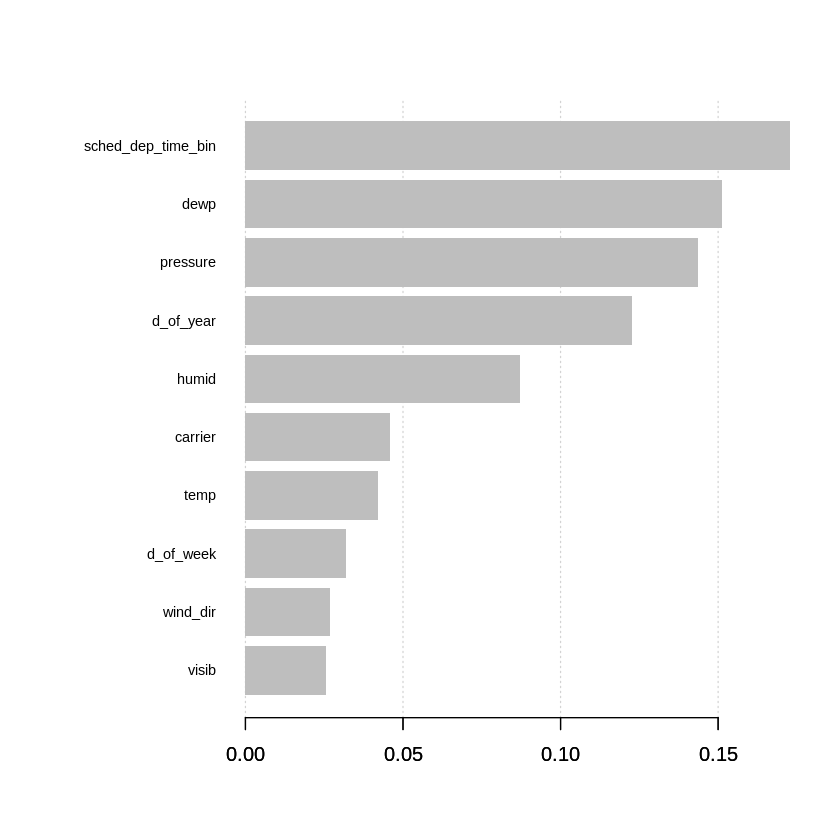

In [0]:
xgb.plot.importance(importance_matrix, top_n = 10, measure = "Gain") # using information gain 

In [0]:
pred_xgb <- predict(xgb.fit, features_test)

- XGBoost Matrices

In [0]:
mae_xgb <- mae(fl_test$dep_delay, pred_xgb)
mae_xgb

mse_xgb <- mse(fl_test$dep_delay, pred_xgb)#Calculate Mean Squared Error (MAE) for test data
mse_xgb

rmse_xgb <- rmse(fl_test$dep_delay, pred_xgb)#Calculate Root Mean Squared Error for test data
rmse_xgb

[1] 18.38036

[1] 1169.548

[1] 34.19866

---
#Metrics on 'fltest.csv.gz'
---

##17. XGB metrics on the new "fltest.csv.gz" test data

- **Preprocess the new test data**

In [0]:
flight_Newtest <- read_csv("https://github.com/SFUStatgen/SFUStat452/raw/master/Project652/fltest.csv.gz")

flTest <- flight_Newtest
#Drop columns where there are more than 12.5% missing values
flTest <- flTest[, -which(colMeans(is.na(flight_Newtest)) > 0.125)]
#Next, Drop the rows which has the NA entries
flTest <- na.omit(flTest)

for(i in 1:ncol(flTest)) {
  if(typeof(flTest[[i]]) == "character") {
    flTest[[i]] <- as.numeric(unlist(lapply(flTest[[i]], murmur3.32)))
    
  }
}

unique(flight_Newtest$carrier)
unique(flTest$carrier)

flTest <- as.data.frame(subset(flTest, select=-c(year.x, month, day, hour, minute, tzone, dst, tz, name, tailnum, flight, dep_time, arr_time, arr_delay, air_time)))
#quantile(fl$dep_delay, probs = c(0.01,0.05,0.1,0.25,.5,.75,.90,.95,.99))
den <- nrow(flTest)+1 # to avoid truncate of last value during ranking 
flTest <- flTest %>% mutate(dep_delay_ranked = rank(dep_delay)/den)
flTest <- flTest %>% mutate(precip = as.numeric(flTest$precip > 0))

flTest <- flTest %>% mutate(sched_dep_time_bin = as.numeric(floor(flTest$sched_dep_time/100))) %>% select(-sched_dep_time)

flTest <- flTest %>% mutate(sched_arr_time_bin = as.numeric(floor(flTest$sched_arr_time/100))) %>% select(-sched_arr_time)

flTest <- flTest %>% mutate(d_of_year = as.numeric(strftime(flTest$time_hour, format = "%j"))) %>% mutate(d_of_week = as.numeric(strftime(flTest$time_hour, format = "%w"))) %>% mutate(m_of_year = as.numeric(strftime(flTest$time_hour, format = "%m"))) %>% select(-time_hour)

flTest <- mutate(flTest,logdistance = log(distance)) %>% select(-distance)
flTest <- mutate(flTest,logalt = log(alt)) %>% select(-alt, -dep_delay_ranked)

- **Load the entire training data to retrain the models**

In [0]:
flight_train <- read_csv("https://github.com/SFUStatgen/SFUStat452/raw/master/Project652/fltrain.csv.gz")

fl <- flight_train
#Drop columns where there are more than 12.5% missing values
fl <- fl[, -which(colMeans(is.na(flight_train)) > 0.125)]
#Next, Drop the rows which has the NA entries
fl <- na.omit(fl)

for(i in 1:ncol(fl)) {
  if(typeof(fl[[i]]) == "character") {
    fl[[i]] <- as.numeric(unlist(lapply(fl[[i]], murmur3.32)))
    
  }
}


unique(flight_train$carrier)
unique(fl$carrier)

fl <- as.data.frame(subset(fl, select=-c(year.x, month, day, hour, minute, tzone, dst, tz, name, tailnum, flight, dep_time, arr_time, arr_delay, air_time)))
#quantile(fl$dep_delay, probs = c(0.01,0.05,0.1,0.25,.5,.75,.90,.95,.99))
den <- nrow(fl)+1 # to avoid truncate of last value during ranking 
fl <- fl %>% mutate(dep_delay_ranked = rank(dep_delay)/den)
fl <- fl %>% mutate(precip = as.numeric(fl$precip > 0))

fl <- fl %>% mutate(sched_dep_time_bin = as.numeric(floor(fl$sched_dep_time/100))) %>% select(-sched_dep_time)

fl <- fl %>% mutate(sched_arr_time_bin = as.numeric(floor(fl$sched_arr_time/100))) %>% select(-sched_arr_time)

fl <- fl %>% mutate(d_of_year = as.numeric(strftime(fl$time_hour, format = "%j"))) %>% mutate(d_of_week = as.numeric(strftime(fl$time_hour, format = "%w"))) %>% mutate(m_of_year = as.numeric(strftime(fl$time_hour, format = "%m"))) %>% select(-time_hour)

fl <- mutate(fl,logdistance = log(distance)) %>% select(-distance)
fl <- mutate(fl,logalt = log(alt)) %>% select(-alt, -dep_delay_ranked)

In [0]:
fl_train <- fl 
dim(fl_train)

In [0]:
# variable names
features <- setdiff(names(fl_train), "dep_delay")

# Create the treatment plan from the training data
treatplan <- vtreat::designTreatmentsZ(fl_train, features, verbose = FALSE)
# Prepare the training data
features_train <- vtreat::prepare(treatplan, fl_train) %>% as.matrix()
response_train <- fl_train$dep_delay

# Prepare the test data
# features_test <- vtreat::prepare(treatplan, fl_test) %>% as.matrix()
# response_test <- fl_test$dep_delay

set.seed(124)
params <- list(
  eta = 0.01,
  max_depth = 5,
  min_child_weight = 5,
  subsample = 0.65,
  colsample_bytree = 1
)
xgb.fit <- xgboost(
  params = params,
  data = features_train,
  label = response_train,
  nrounds = 1000,
  nfold = 5,
  objective = "reg:linear",  # for regression models
  verbose = 0,               # silent
  early_stopping_rounds = 10 # tells XgBoost to stop if there's no improvement for 10 consecutive trees
)


- **metrics on new 'fltest' using XGB**

In [0]:
# variable names
features_flTest <- setdiff(names(flTest), "dep_delay")

# Create the treatment plan from the training data
treatplan_flTest <- vtreat::designTreatmentsZ(flTest, features_flTest, verbose = FALSE)
# Prepare the training data
features_flTest <- vtreat::prepare(treatplan_flTest, flTest) %>% as.matrix()
response_flTest <- flTest$dep_delay

pred_xgb_flTest <- predict(xgb.fit, features_flTest)

mae_xgb_flTest <- mae(response_flTest, pred_xgb_flTest)
mae_xgb_flTest
mse_xgb_flTest <- mse(response_flTest, pred_xgb_flTest)#Calculate Mean Squared Error (MAE) for test data
mse_xgb_flTest
rmse_xgb_flTest <- rmse(response_flTest, pred_xgb_flTest)#Calculate Root Mean Squared Error for test data
rmse_xgb_flTest


[1] 18.17025

[1] 1149.243

[1] 33.90049

##18. Baseline metrics on 'fltest.csv.gz'

In [0]:
mean_test <- abs(mean(flTest$dep_delay))
fl_test_dummy <- flTest %>% mutate(dep_delay_calc = abs(flTest$dep_delay - mean_test)) %>% select(dep_delay_calc)
mae_dummy_test <- mean(fl_test_dummy$dep_delay_calc)
mae_dummy_test

mse_dummy_test <- var(flTest$dep_delay)
mse_dummy_test#Mean Squared Error
rmse_dummy_test <- sqrt(var(flTest$dep_delay))
rmse_dummy_test#Root Mean Squared Error

[1] 21.24254

[1] 1402.446

[1] 37.44924

##19. GAM metrics on 'fltest.csv.gz'

In [0]:
dim(fl_train)

[1] 165021     21

In [0]:
gam.fit <- gam(
  formula = dep_delay ~ .,
  family = gaussian,
  data = fl_train
  )
pred_gam_flTest <- predict(gam.fit, flTest)

mae_gam_flTest <- mae(flTest$dep_delay, pred_gam_flTest)#mean absolute error for the gam
mae_gam_flTest
mse_gam_flTest <- mse(flTest$dep_delay, pred_gam_flTest)#Calculate Mean Squared Error (MAE) for test data 
mse_gam_flTest
rmse_gam_flTest <- rmse(flTest$dep_delay, pred_gam_flTest)# Calculate Root Mean Squared Error for test data
rmse_gam_flTest

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

[1] 20.17662

[1] 1315.898

[1] 36.27532

##20. Lasso regression metrics on 'fltest.csv.gz'

In [0]:
X_train_flTest <- model.matrix(dep_delay ~., data=fl_train)

lambdas <- 10^{seq(from=-1,to=4,length=100)}
cv.lafit <- cv.glmnet(X_train_flTest,fl_train$dep_delay,alpha=1,lambda=lambdas)
# plot(cv.lafit)
best_lam <- cv.lafit$lambda.min

X_test_flTest <- model.matrix(dep_delay ~., data=flTest)

#retrain with best lambda 
lasso_best <- glmnet(X_train_flTest,fl_train$dep_delay, alpha = 1, lambda = best_lam)
pred <- predict(lasso_best, s = best_lam, newx =X_test_flTest)


#Calculate Mean Absolute Error (MAE) for test data
mae_lasso <- mae(flTest$dep_delay, pred)
mae_lasso
#Calculate Mean Squared Error (MAE) for test data
mse_lasso <- mse(flTest$dep_delay, pred)
mse_lasso
#Calculate Root Mean Squared Error for test data
rmse_lasso <- rmse(flTest$dep_delay, pred)
rmse_lasso


[1] 20.16036

[1] 1316.308

[1] 36.28096

##21. Ridge regression metrics on 'fltest.csv.gz'

In [0]:
# X_train_flTest <- model.matrix(dep_delay ~., data=fl_train)

lambdas <- 10^seq(2, -2, by = -.1)
cv.rifit <- cv.glmnet(X_train_flTest,fl_train$dep_delay,alpha=0,lambda=lambdas)
# plot(cv.lafit)
best_lam <- cv.rifit$lambda.min

# X_test_flTest <- model.matrix(dep_delay ~., data=flTest)

#retrain with best lambda 
ridge_best <- glmnet(X_train_flTest,fl_train$dep_delay, alpha = 0, lambda = best_lam)
pred <- predict(ridge_best, s = best_lam, newx =X_test_flTest)


#Calculate Mean Absolute Error (MAE) for test data
mae_ridge <- mae(flTest$dep_delay, pred)
mae_ridge
#Calculate Mean Squared Error (MAE) for test data
mse_ridge <- mse(flTest$dep_delay, pred)
mse_ridge
#Calculate Root Mean Squared Error for test data
rmse_ridge <- rmse(flTest$dep_delay, pred)
rmse_ridge


[1] 20.17558

[1] 1315.944

[1] 36.27594

##22. GBM metrics on 'fltest.csv.gz'

[1] 36.24889

[1] 2500

[1] 19.77733

[1] 1274.885

[1] 35.70553

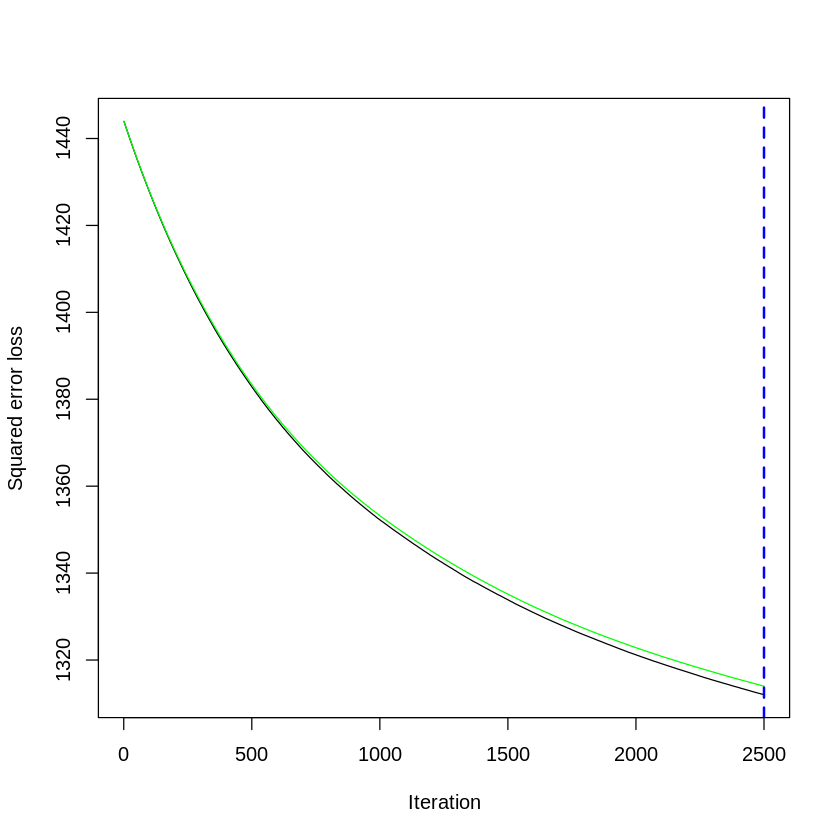

In [0]:
gbm.fit <- gbm(
  formula = dep_delay ~ .,
  distribution = "gaussian",
  data = fl_train,
  n.trees = 2500,
  interaction.depth = 3,
  shrinkage = 0.001,
  cv.folds = 5,
  n.cores = NULL, # will use all cores by default
  verbose = FALSE
)

# summary.gbm(gbm.fit, n.trees = 2000, cBars=10, plotit=TRUE, normalize=TRUE, order=TRUE, las = 1)#Print the feature importance of the fitted GBM model
# sched_dep_time_bin, dewp, pressure, humid are important features with more than 10%
# There were 20 predictors of which 15 had non-zero influence.




sqrt(min(gbm.fit$cv.error))# rmse of cv error
gbm.perf(gbm.fit, method = "cv")



pred_gbm <- predict(gbm.fit, n.trees = 2500, flTest)#Predict the target `dep_delay` on `fl_test`
mae_gbm <- mae(flTest$dep_delay, pred_gbm) #Calculate Mean Absolute Error (MAE) for test data
mae_gbm
mse_gbm <- mse(flTest$dep_delay, pred_gbm)#Calculate Mean Squared Error (MAE) for test data
mse_gbm
rmse_gbm <- rmse(flTest$dep_delay, pred_gbm)#Calculate Root Mean Squared Error for test data
rmse_gbm

##23. RF on train/test split.  RF on 'fltest.csv' holdout test set

In [0]:
#flTest2  <- flTest # storing for RF holdout set metrics
# flTest  <- fl_test

#set.seed(222)
#   default RF model
#   rf.fit <- randomForest(
#   formula = dep_delay ~ .,
#   data    = fl_train
# )


# pred_rf <- predict(rf.fit, flTest)

# mae_rf_flTest <- mae(flTest$dep_delay, pred_rf)
# mae_rf_flTest.
# mse_rf_flTest <- mse(flTest$dep_delay, pred_rf)#Calculate Mean Squared Error (MAE) for hold out data
# mse_rf_flTest
# rmse_rf_flTest <- rmse(flTest$dep_delay, pred_rf)#Calculate Root Mean Squared Error for holout data
# rmse_rf_flTest
# plot(rf.fit)

In [0]:

#set.seed(222)
# # default RF model
# rf.fit <- randomForest(
#   formula = dep_delay ~ .,
#   data    = fl_train # whole training data
# )


# pred_rf <- predict(rf.fit, flTest2)

# mae_rf_flTest <- mae(flTest2$dep_delay, pred_rf)
# mae_rf_flTest.
# mse_rf_flTest <- mse(flTest2$dep_delay, pred_rf)#Calculate Mean Squared Error (MAE) for hold out data
# mse_rf_flTest
# rmse_rf_flTest <- rmse(flTest2$dep_delay, pred_rf)#Calculate Root Mean Squared Error for holout data
# rmse_rf_flTest
# plot(rf.fit)